<a href="https://colab.research.google.com/github/iskra3138/ImageSr/blob/master/6_GCP_Serving_FN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 개요

본 예제는 앞서 TF2.x으로 학습한 5종 꽃분류 모델을 TF1.x 환경에서 불러와서 GCP AI Platform 모델로 Serving 하는 예제입니다.


본 가이드 작성의 목적은 우선적으로 데모 환경 구축 시 GCP를 이용하실 분들께 도움이 될 것 같아서입니다.

보통 클라우드에서 딥러닝 시스템 or 데모환경을 구축할 때, GCP Instance를 이용합니다.

service를 목적으로 항상 작동되야 하는 시스템과 달리 데모는 상시 발생하는 event가 아니다 보니, 비용 절감을 위해 데모 시에만 instance를 올리고, 사용하지 않을 때는 instance를 내리곤 합니다. 
 - 물론 예산이 많다면 여기서 skip하셔도 됩니다.
 - 시스템도 자동으로 scalable하게 제공하려면 AI Platform Prediction 서비스를 사용하는 게 나을 수 있을 것입니다. 자세한 내용은 제 관심사를 넘어가니, 구글 공식 문서들을 참조해주세요 (https://cloud.google.com/ai-platform/prediction/docs)

</br>

비용 관련해서 간단하게 요약하면, GCP Instance로 데모 시스템을 구축하고 상시 체험할 수 있게 한다고 봤을 때, 비싼 GCP Instance를 주구장창 켜 놓아야 하는 것과 달리, 예측 query가 발생할 때만, 분당 요금이 과금된다고 보시면 될 것 같습니다. 그러므로 아무 때나, 누구나 비교적 저렴(?)하게 데모서비스를 체험할 수 있습니다.
  - 참고로 이 경우, 데모시스템은 저렴한 CPU instance나 놀고 있는 로컬 노트북에 flask나 django등으로 웹서버를 구축하되, 딥러닝 모델 예측이 필요한 부분만 REST api를 통해 GCP AI Platform prediction 서비스를 활용한다고 보면 될 것 같습니다.

  --> 본 노트 역시 가속기가 없는. 즉 CPU 버전의 colab 노트입니다.


Prediction 요금 정책은 다음 링크 참조하세요
https://cloud.google.com/ai-platform/prediction/pricing

In [0]:
#@title 요금 정책 관련 내용을 좀 더 자세히 보시려면 double-click 해서 펼쳐 보세요

# There will be no AI Platform charges after you are done testing. 
# Google Cloud Storage incurs charges. 
# Empty the bucket after deployment if you want to avoid these. 
# Once the model is deployed, the bucket is not useful anymore.
### 출처(ctrl+click): https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/keras_mnist_tpu.ipynb#scrollTo=5tzVi39ShrEL

# Both online and batch prediction run your node with distributed 
# processing, so a given request or job can use multiple nodes 
# simultaneously. You are charged for total node usage by the minute,
# using an hourly rate. For example, running two nodes for ten minutes
# is charged the same as running one node for twenty minutes. 
# Online and batch prediction allocate nodes differently, 
# which can have a substantial effect on what you will be charged.
### 출처(ctrl+click): https://cloud.google.com/ai-platform/prediction/docs/overview#node-allocation

# You can affect the scaling of online prediction for a model version
# by specifying a number of nodes to keep running regardless of traffic.
# Setting the number of nodes manually actually stops the service
# from scaling, which means that the number of nodes you specify
# will always be ready, and you will be charged continuously for them.
# You should avoid this unless the number of requests your model
# receives inherently fluctuates faster than the automatic scaling
# can keep up. You set the number of nodes to use by setting
# manualScaling in the Version object you pass to projects.models.versions.create.
## #출처(ctrl+click): https://cloud.google.com/ai-platform/prediction/docs/overview#using_manual_scaling

# Warning: When you manually set the number of nodes to keep ready
# for your version, those nodes are considered to be constantly in use,
# even when not serving predictions.
# This means that you are charged the hourly rate for each node
# from the moment you create the version until you delete it.
# You can't change this value without deploying your model
# to a different version.
### 출처(ctrl+click): https://cloud.google.com/ai-platform/prediction/docs/overview#model_deployment_parameters

# 사전 준비
필요한 라이브러리 및 학습된 모델을 불러옵니다.

아쉽게도 GCP AI Platform Runtime은 아직 2.X를 지원하지 않습니다.
지원하는 환경은 아래 링크를 참조해주세요.
본 예제는 TF 1.15 입니다.

https://cloud.google.com/ai-platform/prediction/docs/runtime-version-list?hl=ko-kr

In [0]:
%tensorflow_version 1.x # %tensorflow_version은 colab 환경에서만 쓸 수 있는 command
import tensorflow as tf

In [0]:
from PIL import Image # inference(prediction)할 때 사용
import json # inference(prediction)할 때 사용
import base64 # inference(prediction)할 때/결과물 확인할 때 사용

import numpy as np # 결과물 확인할 때 사용
from matplotlib import pyplot as plt # 결과물 확인할 때 사용
from io import BytesIO # 결과물 확인할 때 사용
import cv2 # 결과물 확인할 때 사용
import matplotlib.image as mpimg # 결과물 확인할 때 사용

In [0]:
# 기 학습한 모델을 copy해서 사용합니다.
!gsutil cp gs://iskra3138_share/my_flower_tpu_tf2_model.h5 ./
model = tf.keras.models.load_model('my_flower_tpu_tf2_model.h5')

# Deploy the trained model to AI Platform model serving

Push your trained model to production on AI Platform for a serverless, autoscaled, REST API experience.

You will need a GCS (Google Cloud Storage) bucket and a GCP project for this.
Models deployed on AI Platform autoscale to zero if not used. <font color='red'>There will be no AI Platform charges after you are done testing.
Google Cloud Storage incurs charges. Empty the bucket after deployment if you want to avoid these. Once the model is deployed, the bucket is not useful anymore.</font>

## 환경변수 설정 및 Bucket 생성

**지금부터는 GCP 계정이 있어야만 실행할 수 있는 코드들입니다.**

모델을 GCP AI Platform으로 Serving 하기 위해서는 GCP 권한을 획득해야 합니다. 아래 코드셀을 실행시키고 GCP 계정으로 인증합니다. 

In [0]:
from google.colab import auth
auth.authenticate_user()

inference(prediction)할 모델을 CLI 환경에서 serving 하기 위해서 모델이 serving될 project. 저장될 bucket, 관리될 model_name, version 등을 정의합니다.

CLI가 아닌 다른 환경에서 serving 하실 분들은 공식 가이드 문서 참조해주세요

https://cloud.google.com/ai-platform/prediction/docs/deploying-models

In [0]:
# 위에서 인증받은 GCP 계정의 project ID 확인
!gcloud projects list

아래 셀 오른쪽 양식칸 작성 방법
- PROJECT에는 위 셀의 Output에서 Model 을 Serving할 PROJECT_ID를 copy해서 붙여넣습니다.
- BUCKET은 모델 파일(saved file)이 저장될 위치입니다. 쓸데없는 비용 발생을 막기 위해 모델이 deploy된 후 지워줍니다.
  - BUCKET의 이름은 반드시 gs:// 으로 시작합니다.
  - 중복 불가입니다. 자신만의 독자적인 이름을 생성합니다.
- NEW_MODEL은 새로운 모델을 해당 PROJECT에 처음으로 만드는 지 확인하기 위한 변수입니다.
- MODEL_NAME은 관리할 적절한 Model의 이름을 넣어줍니다. PROJECT내 동일 이름이 있으면 새로 생성이 안됩니다.
- MODEL_VERSION은 동일 Model에 여러 버전을 만들 경우 지정해줍니다. 역시 동일 버전이 이미 있다면 새롭게 버전 생성이 안됩니다.

In [0]:
import re

PROJECT = "" #@param {type:"string"}
BUCKET = "gs://"  #@param {type:"string", default:"jddj"}
NEW_MODEL = True #@param {type:"boolean"}
MODEL_NAME = "flowers" #@param {type:"string"}
MODEL_VERSION = "v1" #@param {type:"string"}

assert PROJECT, 'For this part, you need a GCP project. Head to http://console.cloud.google.com/ and create one.'
assert re.search(r'gs://.+', BUCKET), 'For this part, you need a GCS bucket. Head to http://console.cloud.google.com/storage and create one.'

Model이 저장될 Bucket을 CLI로 생성합니다.

In [0]:
### option argument가 앞에오고 BUCKET이 제일 뒤로 감
!gsutil mb -p $PROJECT $BUCKET

In [0]:
# 잘 만들어졌는 지 bucket 목록 확인
!gsutil ls -p $PROJECT

## 모델 정의 및 저장

TF1.x 환경이므로 Serving할 Model을 Graph 구조로 정의합니다.

작성은 아래 링크의 colab note들을 참고했습니다.

단순히 이미지를 입력받아 softmax 값 또는 class만 예측하는 코드들은 아래 노트들만 보셔도 될 것 같습니다.

<keras 만 활용>
https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/01_MNIST_TPU_Keras.ipynb

<Estimator 활용>
https://colab.research.google.com/github/GoogleCloudPlatform/ml-on-gcp/blob/master/tutorials/explanations/ai-explanations-image.ipynb?hl=ko


본 예제는 이미지 배치를 bytestring으로 입력받아 예측한 class와 grad_cam값을 반환하는 Tensorflow graph 구조를 정의합니다.
 - image의 픽셀값을 그대로 사용하면 api로 전달되는 데이터 사이즈가 어마(?)어마(?)합니다. 
 - client PC에서 Image Data를 224*224로 리사이즈한 후, bytestring으로 변경하고 batch를 만듭니다.
 - 그리고 이 값들을 json 형태로 만들어 REST api로 GCP에 넘깁니다.
 - 아래 정의된 Classs는 이 json 파일을 입력으로 받고 결과값을 REST api로 Return합니다.

In [0]:
import os, time # Bucket 이름 생성을 위해 import

# Wrap the model so that we can add a serving function
class ExportModel(tf.keras.Model):
  def __init__(self, model):
    super().__init__(self)
    self.model = model
  
  @tf.function(input_signature=[tf.TensorSpec(shape=[None,1], dtype=tf.string)]) # bytestring으로 넘어오므로 shape은 [None, 1] dtype은 tf.string
  def my_serve(self, images):
    ## batch로 넘어온 bytestring을 image로 decoding 하기 위해 tf.squeeze 와 map_fn(lambda) 적용
    features = tf.squeeze(images, axis=1) 
    images = tf.map_fn(
      lambda img_string: tf.image.decode_jpeg(
          img_string, 
          channels=3
      ),
      features,
      dtype=tf.uint8,
      name='images'
    )
    # normalize from [0,255] to [0,1)
    images = tf.image.convert_image_dtype(images, dtype=tf.float32) # input dtype이 uint8이어야 제대로 작동함
    #images = tf.cast(images, tf.float32)/255   # 학습할때 convert_image_dtype을 쓴 게 아니라면, 그냥 tf.cast를 쓰는 게 안전
    images = tf.image.resize(images, (224,224)) # 실제로는 224,224로 리사이즈한 이미지를 받지만, 결과값 텐서 shape 을 명확히 보여주려고 한번 더 집어넣음
    
    # grad-cam 계산
    model_input = self.model.input
    y_c = self.model.output
    A_k = self.model.get_layer('block14_sepconv2_act').output
    tensor_function = tf.keras.models.Model([model_input], [A_k, y_c])

    conv_outputs, predictions = tensor_function(images)
    classes = tf.argmax(predictions, axis=-1, output_type=tf.dtypes.int32)
    # batch data의 index만드는 법 (지금까지 찾아본 것 중 아래가 가장 간단)
    indices = tf.stack([tf.range(tf.size(classes)), classes], axis=-1)
    # batch data는 tf.gather_nd로 indexing
    loss = tf.gather_nd(predictions, indices)

    grads = tf.gradients(loss, conv_outputs)[0]
    weights = tf.math.reduce_mean(grads, axis=(1, 2))
    # matrix 연산은 einsum이 갑인 듯!!!!
    grad_cam =tf.einsum('nijk,nk->nij', conv_outputs, weights)
    grad_cam = tf.math.maximum(grad_cam, 0)  
  
    print (classes.shape, grad_cam.shape) # 생각한대로 결과가 나오는 지 보려고 shape 출력
    return {'digits': classes, 'grad_cam': grad_cam} # 반환은 dictioinary형태로 해 줌


# 본 코드는 이미 local로 model 파일을 copy한 후에 했기 때문에 실제로 적용할 필요는 없지만 남겨둠
# Must copy the model from TPU to CPU to be able to compose them. 
restored_model = tf.keras.Model.from_config(model.get_config())# 기존 모델 구조로 새로운 모델 구조 정의
restored_model.set_weights(model.get_weights()) # this copies the weights from TPU, does nothing on GPU (모델 weight 복사)

# create the ExportModel and export it to the Tensorflow standard SavedModel format
serving_model = ExportModel(restored_model)
export_path = os.path.join(BUCKET, 'keras_export', str(time.time()))
tf.keras.backend.set_learning_phase(0) # inference only
tf.saved_model.save(serving_model, export_path, signatures={'serving_default': serving_model.my_serve})

print("Model exported to: ", export_path)

# Note: in Tensorflow 2.0, it will also be possible to
# export to the SavedModel format using model.save():
# serving_model.save(export_path, save_format='tf')

생각한대로 잘 작동되는 지 볼 때 아래 코드들이 유용하다고 하네요

In [0]:
# saved_model_cli: a useful too for troubleshooting SavedModels (the tool is part of the Tensorflow installation)
!saved_model_cli show --dir {export_path}
!saved_model_cli show --dir {export_path} --tag_set serve
!saved_model_cli show --dir {export_path} --tag_set serve --signature_def serving_default
# A note on naming:
# The "serve" tag set (i.e. serving functionality) is the only one exported by tf.saved_model.save
# All the other names are defined by the user in the fllowing lines of code:
#      def myserve(self, images):
#                        ******
#        return {'digits': classes, 'grad_cam': grad_cam}
#                 ******              ******
#      tf.saved_model.save(..., signatures={'serving_default': serving_model.myserve})
#                                            ***************

The given SavedModel contains the following tag-sets:
serve
The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"
The given SavedModel SignatureDef contains the following input(s):
  inputs['images'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_images:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['digits'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: StatefulPartitionedCall:0
  outputs['grad_cam'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 7, 7)
      name: StatefulPartitionedCall:1
Method name is: tensorflow/serving/predict


# Deploy the model
This uses the command-line interface(CLI). You can do the same thing through the AI Platform UI at https://console.cloud.google.com/mlengine/models


In [0]:
# 서비스 가능한 region에서 앞서 정의한 project 아래 모델을 만듭니다. 
# 본 예제는 online prediction입니다.
## AI prediction을 지원하는 region은 아래 링크를 참조해주세요
## https://cloud.google.com/ai-platform/prediction/docs/regions
## 참고 
## Compute Engine (N1) machine types for online prediction (beta) are only available in the us-central1 region.
## Using GPUs for online prediction (beta) is only available in the us-central1 region.

if NEW_MODEL:
  !gcloud ai-platform models create {MODEL_NAME} --project={PROJECT} --regions=us-central1

In [0]:
# 해당 모델 아래 특정 버전으로 Bucket에 저장된 모델을 올립니다.
## Create a version of this model (you can add --async at the end of the line to make this call non blocking)
## Additional config flags are available: https://cloud.google.com/ml-engine/reference/rest/v1/projects.models.versions
## You can also deploy a model that is stored locally by providing a --staging-bucket=... parameter
!echo "Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/mlengine/models/{MODEL_NAME}"
!gcloud ai-platform versions create {MODEL_VERSION} \
  --model={MODEL_NAME} \
  --origin={export_path} \
  --project={PROJECT} \
  --runtime-version=1.15 \
  --python-version=3.7 

### bucket 삭제

In [0]:
# bucket 목록 확인
!gsutil ls -p {PROJECT}

In [0]:
!gsutil rm -r {BUCKET} 

In [0]:
# bucket 삭제됨을 확인
!gsutil ls -p {PROJECT}

# Test the deployed model

GCP AI Platfrom에 드디어 모델이 올라갔습니다.

지금부터는 REST API로 던질 json파일 만드는 샘플코드와 

이를 CLI와 python code로 전달하는 방법에 대해 말씀드리겠습니다.

자세한 내용은 아래 공식 가이드 문서 참조해주세요

https://cloud.google.com/ai-platform/prediction/docs/online-predict#requesting_predictions


Your model is now available as a REST API. Let us try to call it. The cells below use the "gcloud ai-platform"
command line tool but any tool that can send a JSON payload to a REST endpoint will work.

먼저 google이 제공하는 test_flowers 이미지 3장을 다운 받습니다.

In [0]:
!mkdir flowers
!gsutil -m cp gs://flowers_model/test_flowers/* ./flowers

mkdir: cannot create directory ‘flowers’: File exists
Copying gs://flowers_model/test_flowers/daisy.jpeg...
Copying gs://flowers_model/test_flowers/dandelion.jpg...
Copying gs://flowers_model/test_flowers/tulip.jpg...


각각의 이미지를 224*224로 리사이즈합니다.

In [0]:
# Resize the images to what our model is expecting (224,224)
test_filenames = []

for i in os.listdir('flowers'):
  img_path = 'flowers/' + i
  with Image.open(img_path) as ex_img:
    resize_img = ex_img.resize([224,224])
    resize_img.save(img_path)
    test_filenames.append(img_path)

base64 라이브러리를 이용해서 json 파일을 만듭니다. 

base64로 만들 때는 instance data가 dictionary이고 key는 'b64'가 되야 하는 것 같습니다.

numpy uint8값을 직접 넘길 때는 앞서 언급한 keras만 사용하는 노트 참고해 주세요
https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/01_MNIST_TPU_Keras.ipynb
```python
## 예
img = Image.open({image_name}).resize((224,224))
npimg = np.asarray(img)
expand_npimg = np.expand_dims(npimg, axis=0) 
with open("digits.json", "w") as f:
  for digit in expand_npimg:
    # the format for AI Platform online predictions is: one JSON object per line
    data = json.dumps({"images": digit.tolist()})  # "images" because that was the name you gave this parametr in the serving funtion my_serve
    f.write(data+'\n')

```

In [0]:
# Prepare our prediction JSON to send to our Cloud model
instances = []
!rm flower-data.txt

for i in test_filenames:
  with open(i, 'rb') as example_img:
    b64str = base64.b64encode(example_img.read()).decode('utf-8')
    with open('flower-data.txt', 'a') as outfile:
      json.dump({'images': [{'b64': b64str}]}, outfile)
      outfile.write('\n')
    instances.append({'images': [{'b64': b64str}]})

rm: cannot remove 'flower-data.txt': No such file or directory


CLI 환경에서 online prediction을 하는 command입니다.
처음 실행할 때는 model이 loading되야 해서 시간이 좀 걸리나, 두번째 부터는 제 속도가 나옵니다.

In [0]:
# Request online predictions from deployed model (REST API) using the "gcloud ml-engine" command line.
predictions = !gcloud ai-platform predict --model={MODEL_NAME} --json-instances flower-data.txt --project={PROJECT} --version {MODEL_VERSION}

결과확인

In [0]:
predictions

['DIGITS  GRAD_CAM',
 '4       [[0.0, 1.140066956395458e-06, 8.090419578365982e-05, 0.00011234077101107687, 6.69563451083377e-05, 3.193646762156277e-06, 1.2201243180243182e-06], [1.2056651144121133e-07, 0.00010326987830922008, 0.0009722881950438023, 0.0012419919949024916, 0.0008960089762695134, 4.990094021195546e-05, 2.6205025278613903e-06], [6.038108040229417e-06, 0.0005589303327724338, 0.0016469864640384912, 0.0017739186296239495, 0.001291915075853467, 0.00013313462841324508, 2.9805366921209497e-06], [6.28840207355097e-05, 0.0010651587508618832, 0.002150934189558029, 0.0021000471897423267, 0.0014336064923554659, 0.00015389015607070178, 2.4714390747249126e-06], [0.00018356030341237783, 0.0014303734060376883, 0.0021629692055284977, 0.001783579122275114, 0.0009948976803570986, 8.962172432802618e-05, 1.7135432699433295e-06], [4.54337932751514e-05, 0.0006590251578018069, 0.0010626690927892923, 0.0007548064459115267, 0.000266910094069317, 2.024394598265644e-05, 0.0], [8.295925908896606e-06

CLI 환경에서 prediction 을 하면 모든 결과가 string으로 떨어집니다. 그러므로 string을 parsing하고 float으로 다시 변경해줘야 합니다.

,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

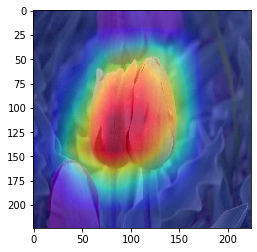

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

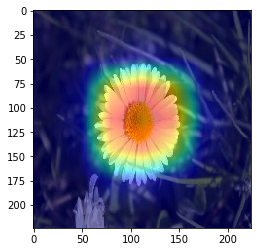

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

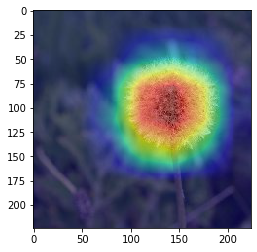

<IPython.core.display.Javascript object>

In [0]:
# CLI 환경 결과물로 원본 이미지 대비 grad-cam 결과 보기
from google.colab import widgets

grid = widgets.Grid(1,3)
for i in range(len(predictions)-1) :
  with grid.output_to(0,i) :
    img = instances[i]['images'][0]['b64']
    im = BytesIO(base64.b64decode(img))
    img = mpimg.imread(im, format='JPG')
    plt.imshow(img, interpolation='nearest')

    predictions_np = np.stack([json.loads(p) for p in predictions[i+1].replace(" ","")[3:].replace("[","").replace("]","").split(',')])
    grad_cam = predictions_np.reshape(7,7)
    grad_cam = cv2.resize(grad_cam, (224, 224))
    plt.imshow(grad_cam, cmap='jet', alpha=0.5)
    plt.show()

# python api 적용

실제로 데모환경은 Flask나 django같은 python 라이브러리를 쓰게 되니, 아래 python 코드들을 참고하시면 될 것 같습니다.

참고한 레퍼런스는 아래입니다.

https://github.com/GoogleCloudPlatform/python-docs-samples/blob/master/ml_engine/online_prediction/predict.py

본 colab 노트는 앞에서 GCP 인증을 받았기 때문에 AI platform predcition API를 쓸 수 있습니다. (즉 비용을 발생시킵니다.)

일반적인 환경에서는 GCP 인증을 key로 받아서 환경변수로 설정해줘야 하는 데 공식 가이드 문서 참고하시면 되겠습니다. 

https://cloud.google.com/ai-platform/prediction/docs/online-predict#requesting_predictions

https://cloud.google.com/ai-platform/prediction/docs/python-client-library

- 실제로 해보니 key를 다운받으면 json 파일로 떨어지는데, 그 내용을 copy해서 장비에 새로운 json 파일 하나 만들고 붙여넣은 다음에 path 잡아줘도 작동됐습니다.
- googleapiclient.discovery는 python3에서 작동합니다. 
  - 혹시 python 실행파일.py 했을 때 없다고 나오면 python3 실행파일.py 한 번 해보세요

In [0]:
"""Examples of using AI Platform's online prediction service."""
import os
import argparse
import base64
import json
from PIL import Image
import numpy as np

# [START import_libraries]
import googleapiclient.discovery
# [END import_libraries]


# python일 때는 파일 자체를 넘기지 않고, 파일 내용(본 코드에서는 batch_strings)을 넘기네요.
# 본 코드의 예는 이미지가 들어있는 폴더가 넘어오면 작동하는 코드입니다. 
def gcp_predictions(img_folder) :
  test_filenames = []
  for i in os.listdir(img_folder):
    img_path = 'flowers/' + i
    with Image.open(img_path) as ex_img:
      resize_img = ex_img.resize([224,224])
      resize_img.save(img_path)
      test_filenames.append(img_path)

  batch_strings = []
  for i in test_filenames:
    with open(i, 'rb') as example_img:
      b64str = base64.b64encode(example_img.read()).decode('utf-8')
      batch_strings.append({'images': [{'b64': b64str}]})
      
  service = googleapiclient.discovery.build('ml', 'v1') #ml
  name = 'projects/{}/models/{}'.format(PROJECT, MODEL_NAME)
  name += '/versions/{}'.format(MODEL_VERSION)

  response = service.projects().predict(
    name=name,
    body={'instances': batch_strings}
  ).execute()

  if 'error' in response:
    raise RuntimeError(response['error'])

  return response['predictions']

## Main
predictions = gcp_predictions('flowers')

결과 확인

In [0]:
predictions

python 환경에서 결과물은 python 기본 데이터 구조들(dictionary, list)로 반환되므로 parsing이 용이합니다.

,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

predicted class:  4


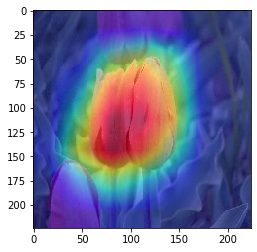

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

predicted class:  0


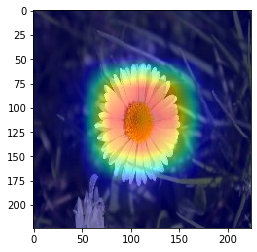

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

predicted class:  1


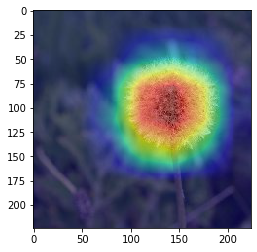

<IPython.core.display.Javascript object>

In [0]:
from google.colab import widgets
from matplotlib import pyplot as plt
import cv2
## python 결과물로 원본 이미지 대비 grad-cam 결과 보기
grid = widgets.Grid(1,3)
img_folder = 'flowers'

for i, img in enumerate(os.listdir(img_folder)):
  with grid.output_to(0, i):
    print ("predicted class: ", predictions[i]['digits'])
    img_path = 'flowers/' + img
    with Image.open(img_path) as ex_img:
      resize_img = ex_img.resize([224,224])
      np_img = np.asarray(resize_img)
      plt.imshow(np_img, interpolation='nearest')

    grad_cam = np.asarray(predictions[i]['grad_cam'])
    grad_cam = cv2.resize(grad_cam, (224, 224))
    plt.imshow(grad_cam, cmap='jet', alpha=0.5)
    plt.show()

### model 삭제

In [0]:
# model list 보기
!gcloud ai-platform models list --project={PROJECT}

In [0]:
# version 부터 삭제
!gcloud ai-platform versions delete {MODEL_VERSION} --model={MODEL_NAME} --project={PROJECT}

In [0]:
# model list로 version 삭제 확인
!gcloud ai-platform models list --project={PROJECT}

In [0]:
# model 삭제
!gcloud ai-platform models delete {MODEL_NAME} --project={PROJECT}

In [0]:
# model 삭제 확인
!gcloud ai-platform models list --project={PROJECT}

## License

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
